In [8]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
from torch import tensor
import numpy as np
from torch.utils.data import Dataset
from sklearn.metrics import mean_squared_error
import random
import os
import matplotlib.pyplot as plt
#from numba import jit
import pickle
from scipy.interpolate import interp1d
from torch.utils.data import DataLoader, random_split
import torch
from torchsummary import summary
import seaborn as sns

# Req for package
import sys
sys.path.append("../")
from SkinLearning.NN.Helpers import train, test, DEVICE, get_parameter_loss, set_seed
from SkinLearning.Utils.Dataset import get_dataset, get_split
from SkinLearning.Utils.Plotting import plot_parameter_bars


# Model

In [9]:
# Up samples to 256 from 128
class Single2D(nn.Module):
    def __init__(self):
        super(Single2D, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, padding=3)
        self.bn1 = nn.BatchNorm2d(128)
        
        self.conv2 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm2d(256)
        
        self.conv3 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm2d(512)
        
        self.conv4 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.conv5 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn5 = nn.BatchNorm2d(128)
        
        
        self.fc1 = nn.Linear(7680, 512)
        self.d1 = nn.Dropout(0.25)
        
        self.fc2 = nn.Linear(512, 256)
        self.d2 = nn.Dropout(0.25)
        
        self.fc3 = nn.Linear(256, 64)
        self.d3 = nn.Dropout(0.25)
        
        self.fc4 = nn.Linear(64, 6)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.unsqueeze(1)
        #x = x.reshape(batch_size, 1, 2, 128)
        print(x.shape)
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
       # x = self.pool4(torch.relu(self.bn4(self.conv4(x))))
        
        x = x.view(batch_size, -1)
        
        x = torch.relu(self.fc1(x))
        x = self.d1(x)
        
        x = torch.relu(self.fc2(x))
        x = self.d2(x)
        
        x = torch.relu(self.fc3(x))
        x = self.d3(x)
        
        
        x = self.fc4(x)
        return x

In [10]:
# Up samples to 128 from 32
class DualDownUp(nn.Module):
    def __init__(self):
        super(DualDownUp, self).__init__()
        self.conv1 = nn.Conv1d(2, 32, kernel_size=5, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=5)
        self.bn1 = nn.BatchNorm1d(32)
        
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(64)
        
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(128)
        
        self.conv4 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn4 = nn.BatchNorm1d(256)
        
        self.fc1 = nn.Linear(768, 128)
        self.d1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(128, 64)
        self.d2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(64, 32)
        self.d3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(32, 6)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool4(torch.relu(self.bn4(self.conv4(x))))
        #x = self.pool5(torch.relu(self.bn5(self.conv5(x))))
        
       # x = self.pool4(torch.relu(self.bn4(self.conv4(x))))
        
        #x = x.view(batch_size, -1)
        x = x.view(batch_size, -1)

        x = torch.relu(self.fc1(x))
        x = self.d1(x)
        
        x = torch.relu(self.fc2(x))
        x = self.d2(x)
        
        x = torch.relu(self.fc3(x))
        x = self.d3(x)
        
        x = self.fc4(x)
        return x

In [11]:
# Up samples to 128 from 32
class DualUpDown(nn.Module):
    def __init__(self):
        super(DualUpDown, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=5)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.conv3 = nn.Conv1d(256, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(128)
        
        self.conv4 = nn.Conv1d(128, 64, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn4 = nn.BatchNorm1d(64)
        
        self.fc1 = nn.Linear(192, 64)
        self.d1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(64, 32)
        self.d2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(32, 16)
        self.d3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(16, 6)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool4(torch.relu(self.bn4(self.conv4(x))))
        #x = self.pool5(torch.relu(self.bn5(self.conv5(x))))
        
       # x = self.pool4(torch.relu(self.bn4(self.conv4(x))))
        
        #x = x.view(batch_size, -1)
        x = x.view(batch_size, -1)

        x = torch.relu(self.fc1(x))
        x = self.d1(x)
        
        x = torch.relu(self.fc2(x))
        x = self.d2(x)
        
        x = torch.relu(self.fc3(x))
        x = self.d3(x)
        
        x = self.fc4(x)
        return x

In [12]:
# Up samples to 128 from 32
class DualDownUp(nn.Module):
    def __init__(self):
        super(DualDownUp, self).__init__()
        self.conv1 = nn.Conv1d(2, 32, kernel_size=5, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=5)
        self.bn1 = nn.BatchNorm1d(32)
        
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(64)
        
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(128)
        
        self.conv4 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn4 = nn.BatchNorm1d(256)
        
        self.fc1 = nn.Linear(768, 128)
        self.d1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(128, 64)
        self.d2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(64, 32)
        self.d3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(32, 6)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool4(torch.relu(self.bn4(self.conv4(x))))
        #x = self.pool5(torch.relu(self.bn5(self.conv5(x))))
        
       # x = self.pool4(torch.relu(self.bn4(self.conv4(x))))
        
        #x = x.view(batch_size, -1)
        x = x.view(batch_size, -1)

        x = torch.relu(self.fc1(x))
        x = self.d1(x)
        
        x = torch.relu(self.fc2(x))
        x = self.d2(x)
        
        x = torch.relu(self.fc3(x))
        x = self.d3(x)
        
        x = self.fc4(x)
        return x

In [13]:
# Up samples to 256 from 128
class DualUp(nn.Module):
    def __init__(self):
        super(DualUp, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(512)
        
        self.conv4 = nn.Conv1d(512, 1024, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn4 = nn.BatchNorm1d(1024)
        
        
        self.fc1 = nn.Linear(7680, 512)
        self.d1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(512, 256)
        self.d2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(256, 64)
        self.d3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(64, 6)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
       # x = self.pool4(torch.relu(self.bn4(self.conv4(x))))
        
        x = x.view(batch_size, -1)
        
        x = torch.relu(self.fc1(x))
        x = self.d1(x)
        
        x = torch.relu(self.fc2(x))
        x = self.d2(x)
        
        x = torch.relu(self.fc3(x))
        x = self.d3(x)
        
        
        x = self.fc4(x)
        return x

In [14]:
# Down samples from 128 features
class DualDown(nn.Module):
    def __init__(self):
        super(DualDown, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding='same')
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.conv2 = nn.Conv1d(128, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(64)
        
        self.conv3 = nn.Conv1d(64, 32, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(32)
        
        self.conv4 = nn.Conv1d(32, 16, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn4 = nn.BatchNorm1d(16)
        
        self.fc1 = nn.Linear(112, 64)
        self.d1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(64, 32)
        self.d2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(32, 16)
        self.d3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(16, 6)

    def forward(self, x):
        #x = x.type(torch.FloatTensor)
        #print(type(x))# Train/test functions
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
        x = self.pool4(torch.relu(self.bn4(self.conv4(x))))
        
        x = x.view(batch_size, -1)
        
        x = torch.relu(self.fc1(x))
        x = self.d1(x)
        
        x = torch.relu(self.fc2(x))
        x = self.d2(x)
        
        x = torch.relu(self.fc3(x))
        x = self.d3(x)
        
        
        
        x = self.fc4(x)
        return x

# Dataset

In [16]:
set_seed()

In [17]:
dataset, scaler = get_dataset()

100%|██████████████████████████████████████████████████████████████████████████████| 2241/2241 [00:35<00:00, 63.73it/s]


## Train/test split

In [10]:
train_loader, test_loader = getSplit(dataset)

In [11]:
len(dataset[0])

2

# Training/testing

In [12]:
downUp = DualDownUp() # Extracts 32, then takes to 128

In [13]:
downUpLoss, downUp_ploss, downUp_vloss = train(train_loader, downUp, val_loader=test_loader, LR=0.0001, epochs=500)

Using: cuda


100%|█████████████████████████| 56/56 [00:00<00:00, 136.40batch/s, counter=0, epoch=135, lastLoss=0.138, valLoss=0.115]


100%|█████████████████████████| 56/56 [00:00<00:00, 135.43batch/s, counter=0, epoch=271, lastLoss=0.129, valLoss=0.124]


100%|██████████████████████████| 56/56 [00:00<00:00, 134.05batch/s, counter=0, epoch=407, lastLoss=0.122, valLoss=0.11]


100%|█████████████████████████| 56/56 [00:00<00:00, 133.26batch/s, counter=0, epoch=499, lastLoss=0.119, valLoss=0.119]

Average train loss: 0.13788852631699824
Average validation loss: 0.12172757774566612


ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
up = DualUp() # Upsamples to 256 features

In [15]:
test(test_loader, downUp, scaler)

(78.79641151428223,
 array([93.63997 , 57.97084 , 99.7139  , 99.39943 , 56.177578, 65.876755],
       dtype=float32),
 0.09976198996106783)

In [ ]:
upLoss, up_ploss, up_vloss = train(train_loader, up, val_loader=test_loader, LR=0.0001, epochs=500, early_stopping=True)

In [ ]:
down = DualDown() # Downsamples from 128 to 32

In [ ]:
downLoss, down_ploss, down_vloss = train(train_loader, down, val_loader=test_loader, LR=0.0001, epochs=500)

In [ ]:
upDown = DualUpDown()

In [ ]:
upDownLoss, upDown_ploss, upDown_vloss = train(train_loader, upDown, val_loader=test_loader, LR=0.0001, epochs=500)

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(30, 6))
x = range(0, 500)

#ax[0][1].set_xlabel("Training Loss")
##ax[1][1].set_xlabel("Validation Loss")

ax[0].set_title("Up Down")
ax[1].set_title("Down Up")
ax[2].set_title("Up")
ax[3].set_title("Down")


for i, res in enumerate([(upDownLoss, upDown_vloss), (downUpLoss, downUp_vloss), (upLoss, up_vloss), (downLoss, down_vloss)]):
    for j in range(2):
        ax[i].plot(x, res[j], c = "b" if j == 0 else "y", label = "Train loss" if j == 0 else "Validation loss")
plt.legend()    
plt.show()

# Results

In [61]:
print(list(zip(["t1", "t2", "t3"], ["v1", "v2", "v3"])))

[('t1', 'v1'), ('t2', 'v2'), ('t3', 'v3')]


In [242]:
sns.set_theme()

"""
    Plots train and test curves of given models
"""
def printCurves(models, names, train_loss, val_loss, epochs=500):
    fig, ax = plt.subplots(
        len(models)//2, len(models)//2, figsize=(35, len(models)*6), sharex=True, sharey=True, constrained_layout=True)
    x = range(0, epochs)
    fig.supxlabel("Epoch", fontsize=45)
    fig.supylabel("MAE", fontsize=45)

    #ax[0][1].set_xlabel("Training Loss")
    ##ax[1][1].set_xlabel("Validation Loss")
    
    tv_loss = list(zip(train_loss, val_loss))
    for i in range(len(models)//2):
        for j in range(len(models)//2):
            ax[i][j].set_title(names[i+j], fontsize=40)
            ax[i][j].xaxis.set_tick_params(labelsize=35)
            ax[i][j].yaxis.set_tick_params(labelsize=35)
            for k in range(2):
                ax[i][j].plot(x, tv_loss[i+j][k], c = "b" if k == 0 else "y", label = "Train loss" if k == 0 else "Validation loss")
    
    
    """ for i in range(len(tv_loss)):
        for j in range(2):
            print(i//2)
            print(0 if i < len(models)//2 else 1, i//len(models)//2)
            ax[0 if i < len(models)//2 else 1][i//len(models)//2].plot(x, tv_loss[i][j], c = "b" if j == 0 else "y", label = "Train loss" if j == 0 else "Validation loss")"""
    
    #plt.xticks(fontsize=14, rotation=90)
    plt.legend()
    plt.show()
    fig.savefig("../Results/testArchitectures.svg", dpi="figure")

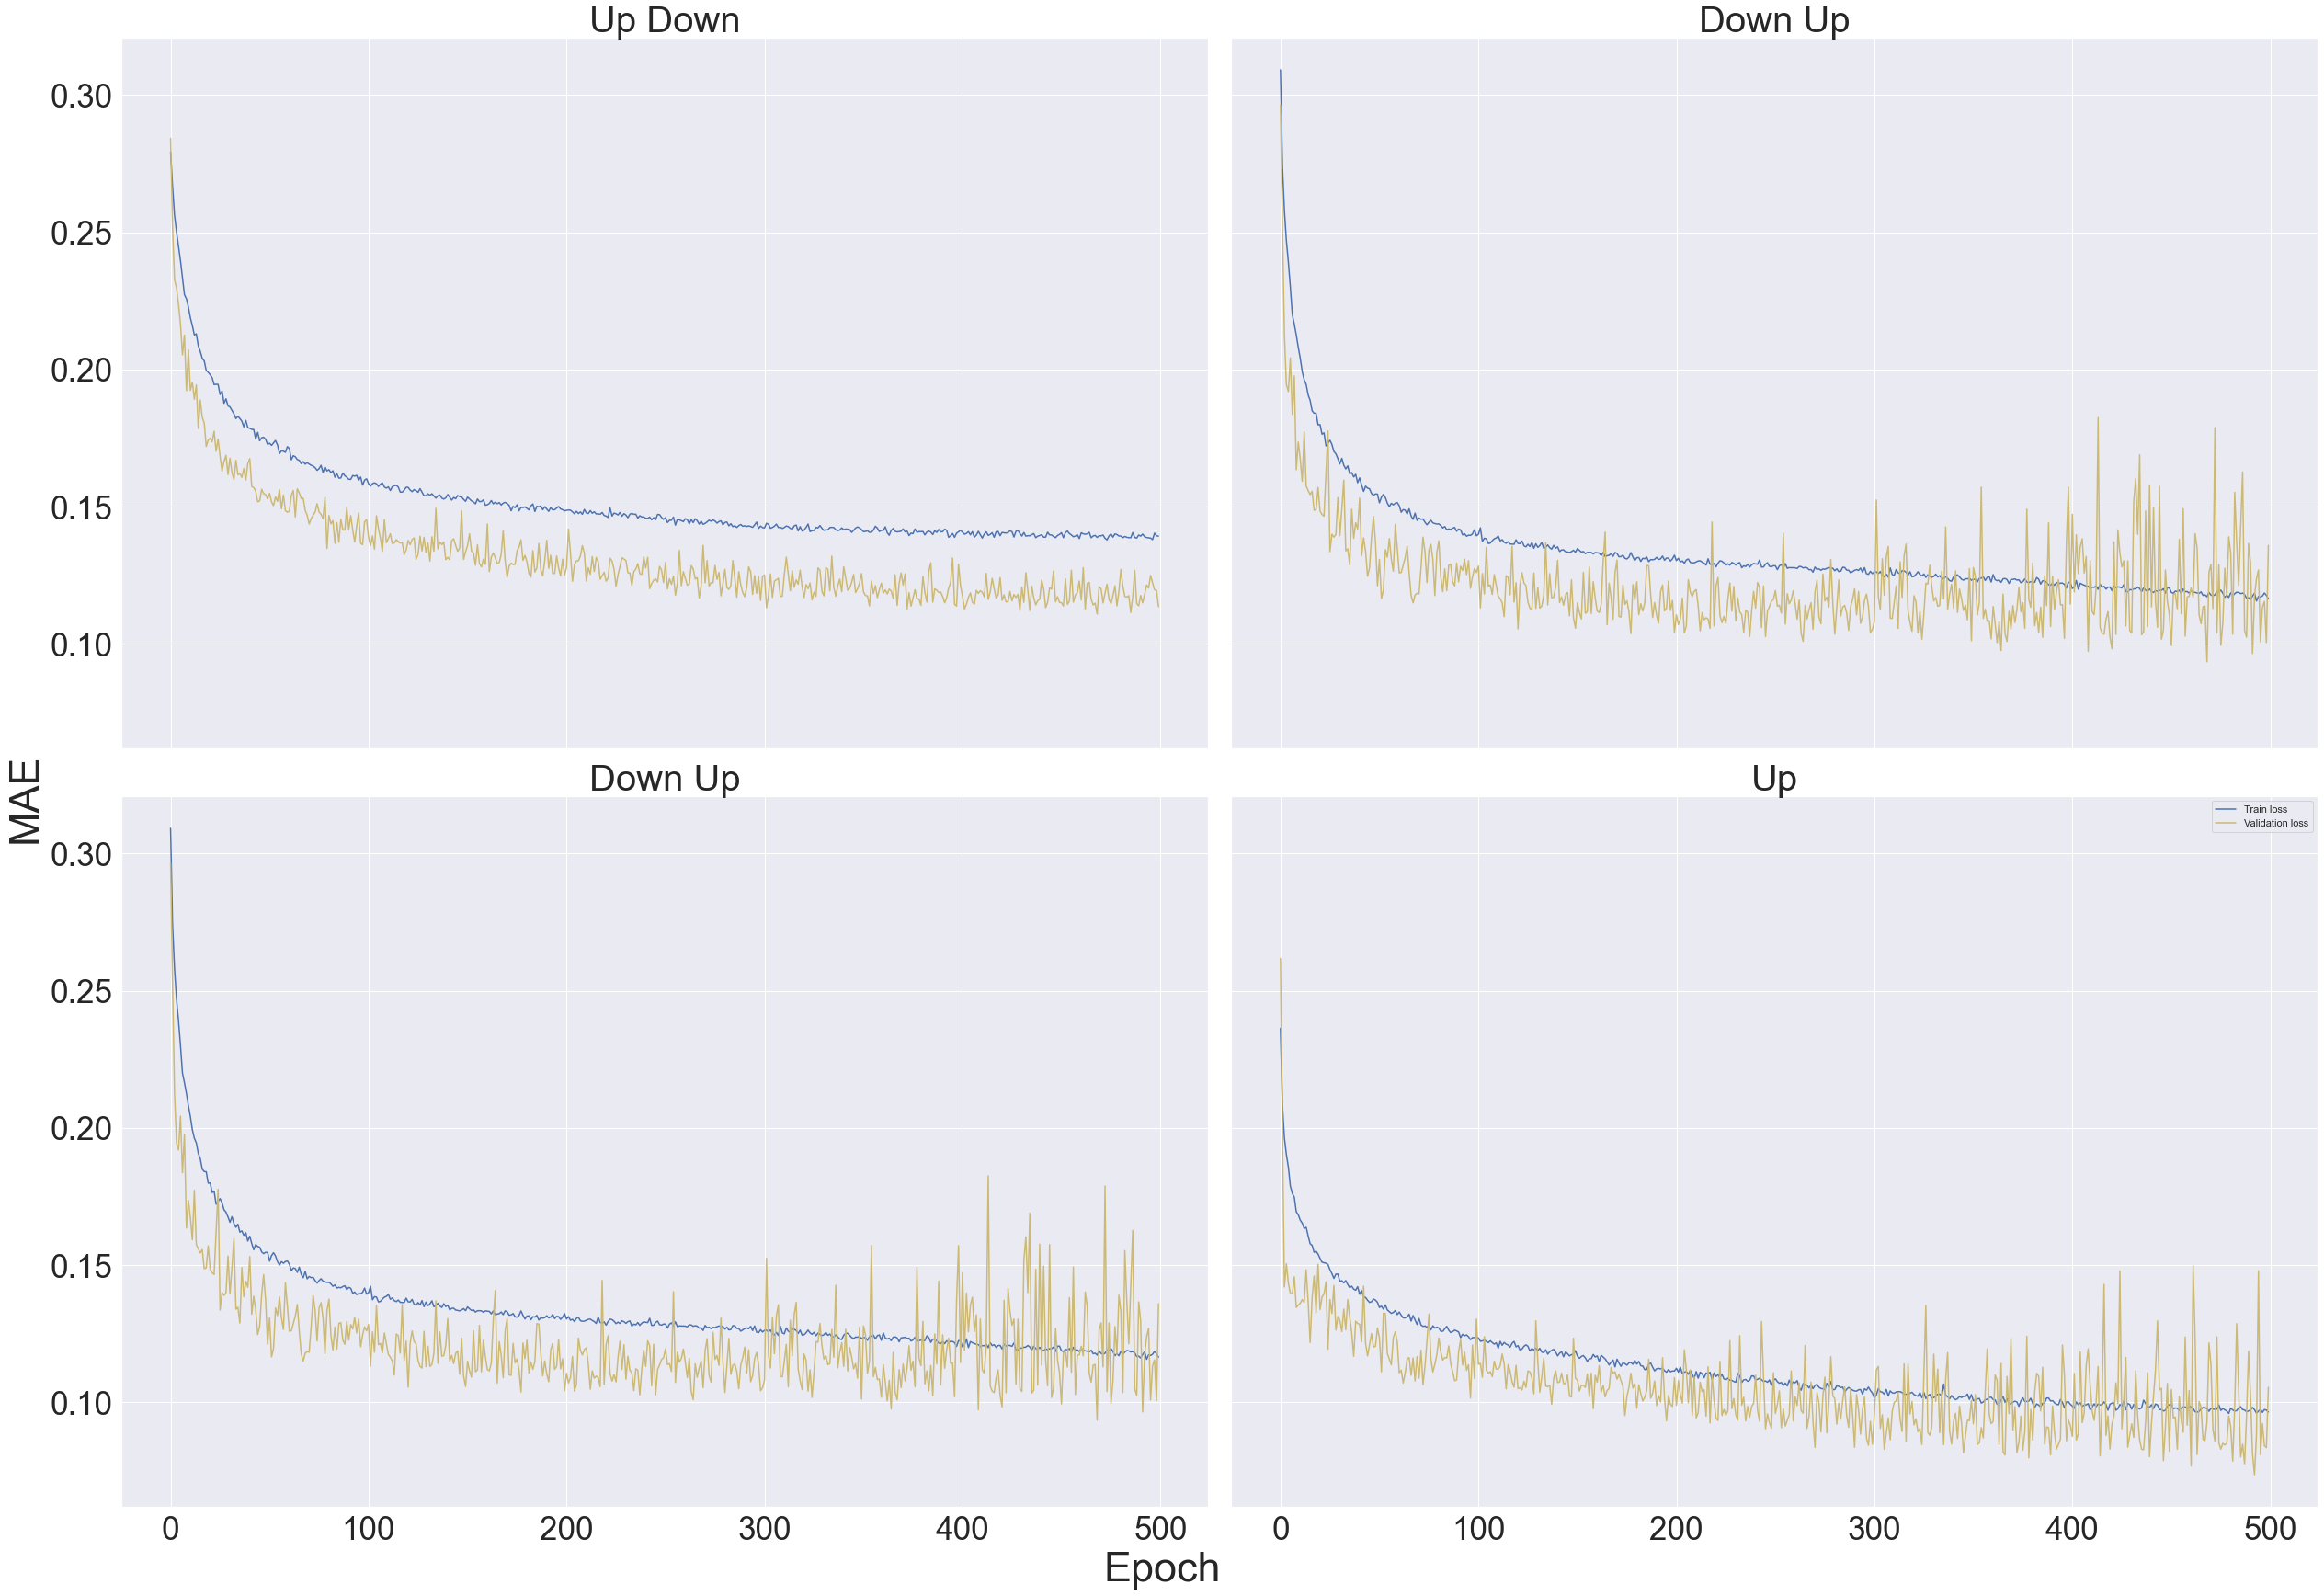

In [243]:
train_loss = [upDownLoss, downUpLoss, upLoss, downLoss]
val_loss = [upDown_vloss, downUp_vloss, up_vloss, down_vloss]
printCurves([upDown, downUp, up, down], ["Up Down", "Down Up", "Up", "Down"], train_loss, val_loss)

4

In [326]:
"""
    Run evaluation and build a dataframe of parameter accuracies
    Accuracies are calculated as 100-loss as a percentage of the original value
"""
def getParameterLoss(models, names, test_loader=test_loader, mspe_based=True):
    params = []
    overall = []
    
    # Run evaluation on all models
    for model in models:
        if mspe_based:
            ps, avg, _ = test(test_loader, model)
        else:
            ps, _, avg = test(test_loader, model)
        overall.append(avg)
        params.append(ps)
    
    all_vals = np.array(params)
    df = pd.DataFrame({
        "Architecture": names,
        "YM (Skin)": all_vals[:, 0],
        "YM (Adipose)": all_vals[:, 1],
        "PR (Skin)": all_vals[:, 2],
        "PR (Adipose)": all_vals[:, 3],
        "Perm (Skin)": all_vals[:, 4],
        "Perm (Adipose)": all_vals[:, 5],
        "Overall": np.mean(overall, axis=1)
    })
    
    df = df.set_index("Architecture")
    df_p = df.style.set_caption(
        'Average percent correctness 100-MAPE' if mspe_based else "Average denormalised correctnessss 100-(abs(target-predicted)/target)*100)").set_table_styles([{
        'selector': 'caption',
        'props': [
            ('color', 'black'),
            ('font-size', '16px'),
            ('text-align', 'center')
        ]
    }])
    display(df_p)
    
    return df
    
"""printVals = lambda x: print(''.join(
    'YM 1: {:.2f}%, YM 2: {:.2f}%, PR 1: {:.2f}%,  PR 2: {:.2f}%, Perm 1: {:.2f}%, Perm 2: {:.2f}%'.format(*x)))    """

"printVals = lambda x: print(''.join(\n    'YM 1: {:.2f}%, YM 2: {:.2f}%, PR 1: {:.2f}%,  PR 2: {:.2f}%, Perm 1: {:.2f}%, Perm 2: {:.2f}%'.format(*x)))    "

In [325]:
DEVICE

device(type='cuda', index=0)

In [14]:
models, names = [upDown, downUp, up, down], ["Up Down", "Down Up", "Up", "Down"]
df = getParameterLoss(models, names, mspe_based=False)

NameError: name 'upDown' is not defined

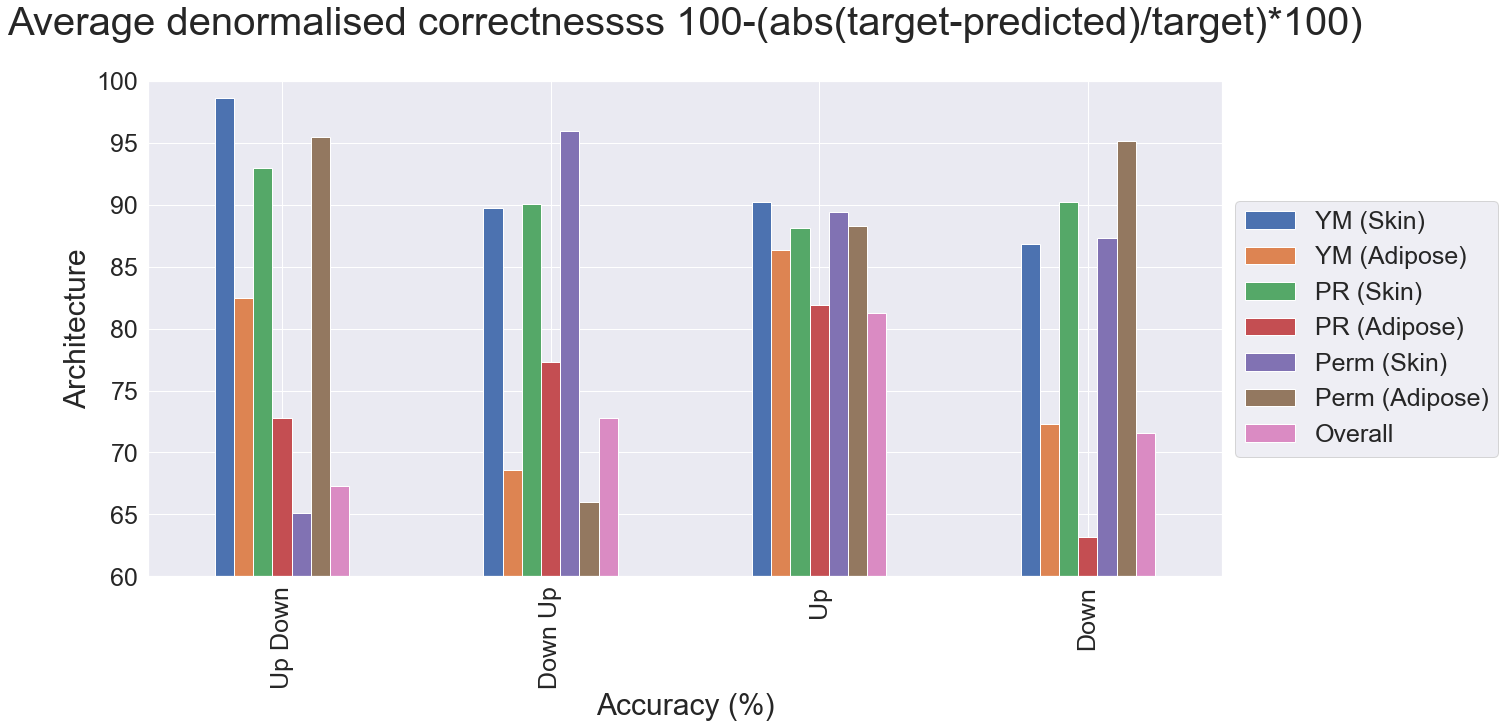

In [339]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10), constrained_layout=True)
df.plot.bar(ax=ax)
ax.xaxis.set_tick_params(labelsize=25)
ax.yaxis.set_tick_params(labelsize=25)
ax.set_ylabel("Architecture", fontsize=30)
ax.set_xlabel("Accuracy (%)", fontsize=30)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),  prop={'size': 25})
ax.set_ylim(60, 100)
ax.set_title("Average denormalised correctnessss 100-(abs(target-predicted)/target)*100)", size=40, y=1.08)
fig.savefig("../Results/testArchitecturesbar.svg", bbox_inches='tight')

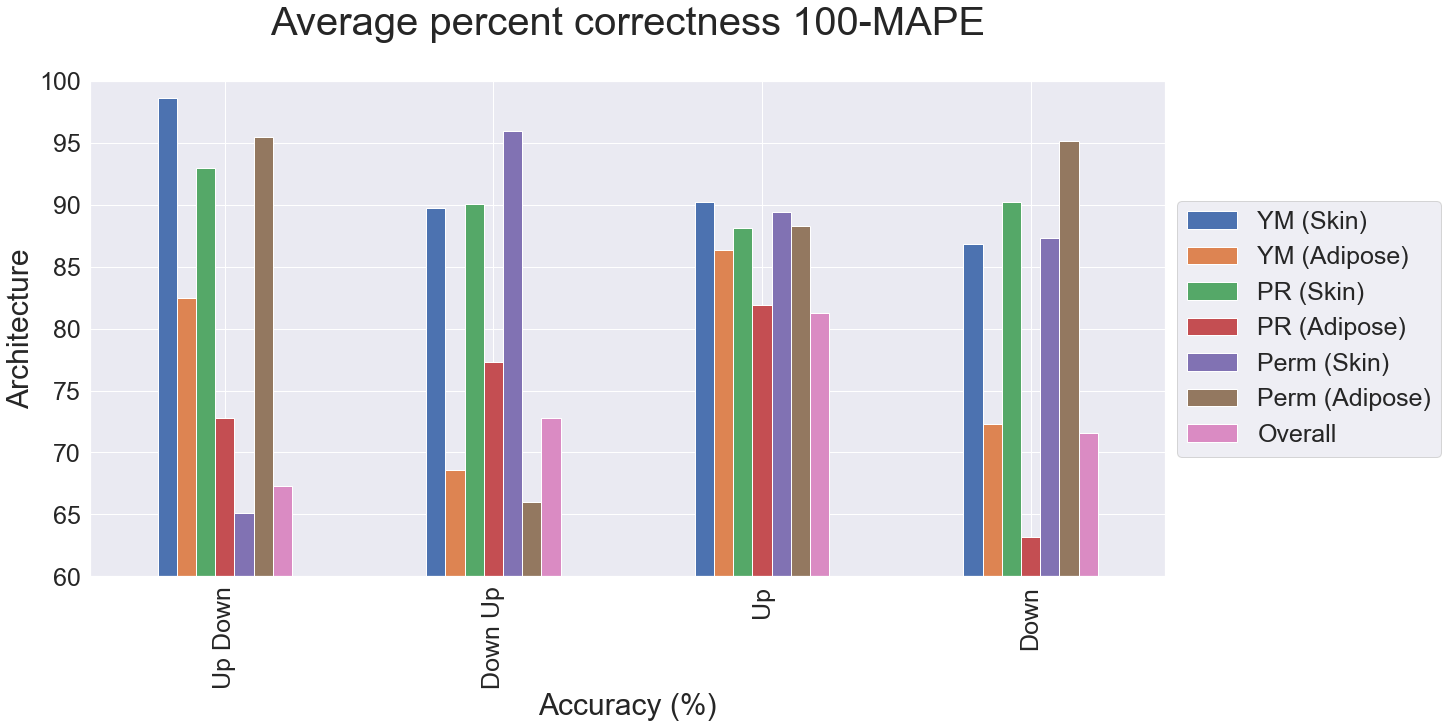

In [341]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10), constrained_layout=True)
df.plot.bar(ax=ax)
ax.xaxis.set_tick_params(labelsize=25)
ax.yaxis.set_tick_params(labelsize=25)
ax.set_ylabel("Architecture", fontsize=30)
ax.set_xlabel("Accuracy (%)", fontsize=30)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),  prop={'size': 25})
ax.set_title("Average percent correctness 100-MAPE", size=40, y=1.08)
ax.set_ylim(60, 100)
fig.savefig("../Results/testArchitecturesbarmspe.svg", bbox_inches='tight')

In [51]:
upDown_p = test(test_loader, upDown)
downUp_p = test(test_loader, downUp)
up_p = test(test_loader, up)
down_p = test(test_loader, down)
all_vals = np.array([upDown_p, downUp_p, down_p, down_p])
#all_vals = np.array([[str(val)+"%" for val in vals] for vals in all_vals])



print("\nUp Down: ")
printVals(upDown_p)

print("\nDown Up: ")
printVals(downUp_p)

print("\nUp: ")
printVals(up_p)

print("\nDown: ")
printVals(down_p)

df = pd.DataFrame({
    "Architecture": ["Up Down", "Down Up", "Up", "Down"],
    "YM (Skin) %": all_vals[:, 0],
    "YM (Adipose) %": all_vals[:, 1],
    "PR (Skin) %": all_vals[:, 2],
    "PR (Adipose) %": all_vals[:, 3],
    "Perm (Skin) %": all_vals[:, 4],
    "Perm (Adipose) %": all_vals[:, 5],
})





100%|█████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 104.29 batch/s]


Up Down: 
YM 1: 93.52%, YM 2: 51.20%, PR 1: 99.72%,  PR 2: 99.34%, Perm 1: 12.20%, Perm 2: 47.81%

Down Up: 
YM 1: 93.03%, YM 2: 63.52%, PR 1: 99.72%,  PR 2: 99.27%, Perm 1: 43.16%, Perm 2: 37.81%

Up: 
YM 1: 93.80%, YM 2: 56.85%, PR 1: 99.73%,  PR 2: 99.33%, Perm 1: 66.08%, Perm 2: 71.51%

Down: 
YM 1: 93.13%, YM 2: 52.93%, PR 1: 99.72%,  PR 2: 99.35%, Perm 1: 44.28%, Perm 2: 40.15%


,YM (Skin) %,YM (Adipose) %,PR (Skin) %,PR (Adipose) %,Perm (Skin) %,Perm (Adipose) %
Architecture,,,,,,
Up Down,93.524780,51.200672,99.724449,99.342567,12.195221,47.807529
Down Up,93.033447,63.519543,99.718063,99.265930,43.159847,37.814861
Up,93.125008,52.925739,99.723457,99.350487,44.275627,40.154030
Down,93.125008,52.925739,99.723457,99.350487,44.275627,40.154030


In [247]:
np.min([[0, 1, 2, 3], [1, 2, 3, 4], [4,5, 5, 5]], axis=1)

array([0, 1, 4])

,Min. train loss,Final train loss,Min. val loss,Final val loss
Model,,,,
Up Down,0.137940,0.139313,0.110945,0.113585
Down Up,0.115668,0.116483,0.093530,0.135934
Up,0.095953,0.096501,0.073617,0.105497
Down,0.136257,0.138345,0.109146,0.118715


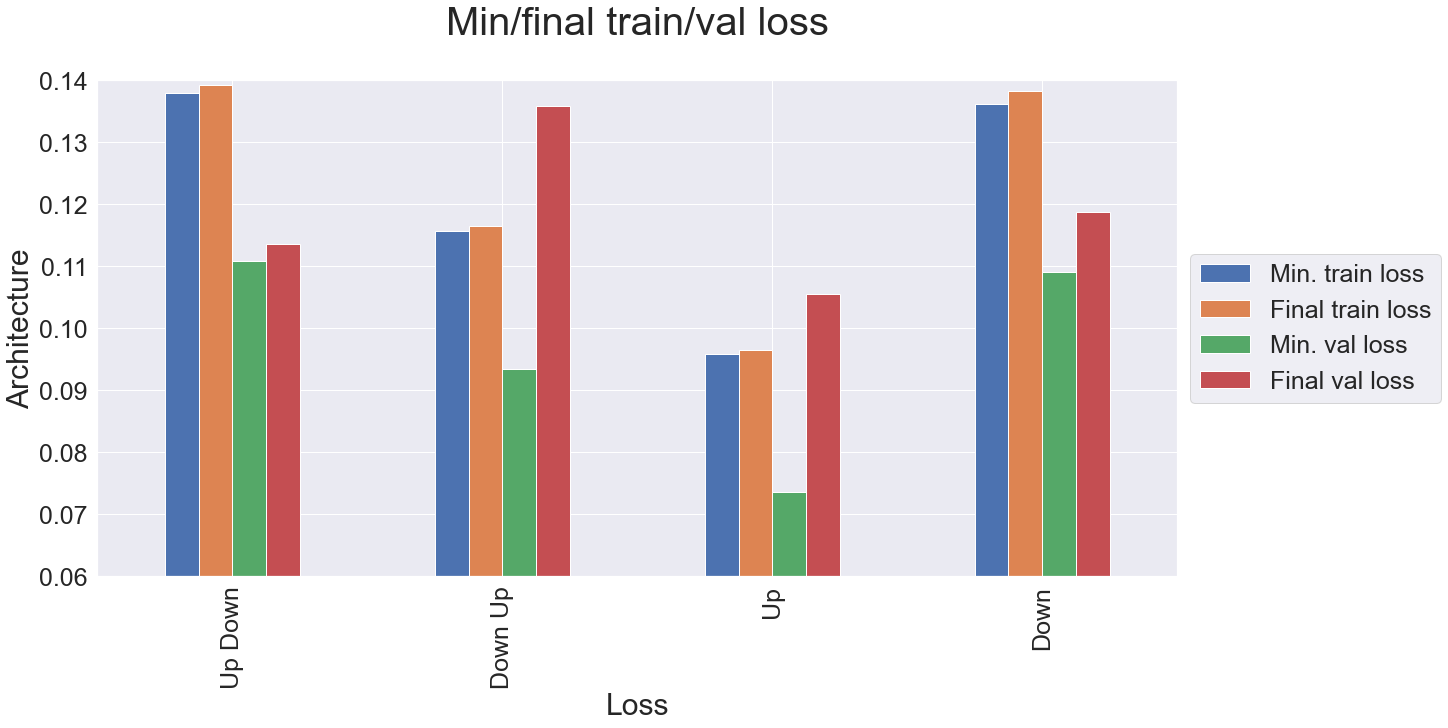

In [353]:
min_final = pd.DataFrame({
    "Model": names,
    "Min. train loss": np.min(train_loss, axis=1),
    "Final train loss": np.array(train_loss)[:, -1],
    "Min. val loss": np.min(val_loss, axis=1),
    "Final val loss": np.array(val_loss)[:, -1]
})

min_final = min_final.set_index("Model")
display(min_final)

fig, ax = plt.subplots(1, 1, figsize=(20, 10), constrained_layout=True)
min_final.plot.bar(ax=ax)
ax.xaxis.set_tick_params(labelsize=25)
ax.yaxis.set_tick_params(labelsize=25)
ax.set_ylabel("Architecture", fontsize=30)
ax.set_xlabel("Loss", fontsize=30)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),  prop={'size': 25})
ax.set_title("Min/final train/val loss", size=40, y=1.08)
ax.set_ylim(0.06, 0.14)
fig.savefig("../Results/minfinalbar.svg", bbox_inches='tight')

In [116]:
wiith open("tvloss.pkl") as f:
    pickle.dumps

[5.364418029785156e-07,
 0.0757797509431839,
 0.060605406761169434,
 0.21840360760688782,
 0.15401411056518555,
 0.37659168243408203]